In [2]:

from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

# Use Floyd's cifar-10 dataset if present
floyd_cifar10_location = '/input/cifar-10/python.tar.gz'
if isfile(floyd_cifar10_location):
    tar_gz_path = floyd_cifar10_location
else:
    tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

All files found!


## Exploring the Data
The dataset is broken into batches to prevent your machine from running out of memory.  The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 1:
Image - Min Value: 5 Max Value: 254
Image - Shape: (32, 32, 3)
Label - Label Id: 9 Name: truck


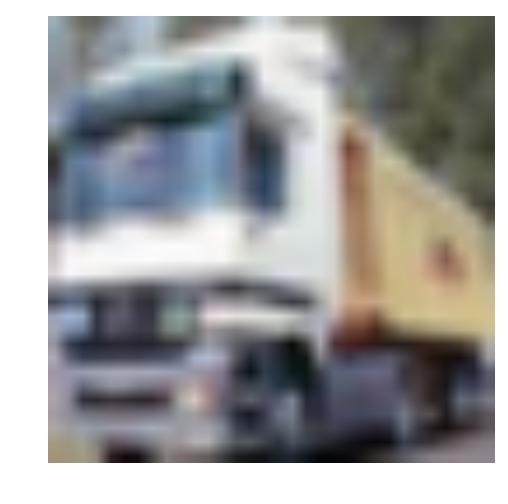

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 1
sample_id = 1
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implement Preprocess Functions
### Normalizing the sample image data

In [4]:
#import numpy as np
#from sklearn.preprocessing import normalize
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """    
    return np.divide(x,255.0)

tests.test_normalize(normalize)

Tests Passed


### Performing One-hot encode

In [5]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(n_values=10)

def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    numpy_single_array = np.array(x).reshape(-1,1)
    encoder_after_fit_transform = enc.fit_transform(numpy_single_array).toarray()
    
    return encoder_after_fit_transform


tests.test_one_hot_encode(one_hot_encode)

Tests Passed


### Randomize Data

## Preprocess all the data and save it
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [9]:
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Check Point
The preprocessed data has been saved to disk.

In [10]:
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

In [12]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    return tf.placeholder(tf.float32, shape=(None,image_shape[0],image_shape[1],image_shape[2]),name='x')


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    return tf.placeholder(tf.float32, shape=(None,n_classes), name='y')


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    return tf.placeholder(tf.float32,name='keep_prob')


tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


### Convolution and Max Pooling Layer

In [13]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    
    
    """
    # weight = tf.Variable(tf.tuncated_normal(height,width,input_depth,output_depth))
    # height, width = conv_ksize[0:1] 
    # input_depth = x_tensor.get_shape().as_list()[3]
    # output_depth = conv_num_outputs
    weights = tf.Variable(tf.random_normal([conv_ksize[0],conv_ksize[1],x_tensor.get_shape().as_list()[3],conv_num_outputs]))
    # bias = tf.Variable(tf.zeroes(output_depth)) # make all the bias as zero 
    bias = tf.Variable(tf.zeros(conv_num_outputs))
    # padding recommended is 'same'
    pad = 'SAME'
    # Now applying convolution 
    x = tf.nn.conv2d(x_tensor,weights, strides=[1,conv_strides[0],conv_strides[1],1],padding=pad)
    # Adding bias 
    x = tf.nn.bias_add(x,bias)
    # Applying nonlinear activation (rectified linear unit) to the convolution
    x = tf.nn.relu(x)
    #Applying max_pool
    #given ksize is2-D tuple.. convert it to pool_ksize
    pool_size = [1,pool_ksize[0],pool_ksize[1],1]
    #given pool_strides is 2-D tuple .. convert it to pool_strides
    pool_strides = [1,pool_strides[0],pool_strides[1],1]
    # padding recommended is 'same' which is already defined
    #calculate and return the max_pool function 
    return tf.nn.max_pool(x,ksize=pool_size,strides=pool_strides,padding=pad)

tests.test_con_pool(conv2d_maxpool)

Tests Passed


### Flatten Layer

In [16]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # Idea is to change from 4-d tensor to 2-D tensor
    # link - https://www.tensorflow.org/api_docs/python/tf/contrib/layers/flatten
    
    # image is three dimension in shape
    # Arguments:
    # inputs: a tensor of size [batch_size, ...] as per documentation. 
    # Flattens the input while maintaining the batch_size.
    #Assumes that the first dimension represents the batch
    
    batch_size = x_tensor.get_shape().as_list()[0]
    new_size = x_tensor.get_shape().as_list()[1] * x_tensor.get_shape().as_list()[2] * x_tensor.get_shape().as_list()[3]
    
    return tf.contrib.layers.flatten(x_tensor, [batch_size, new_size])


tests.test_flatten(flatten)

Tests Passed


### Fully-Connected Layer

In [17]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    mean = 0
    std_deviation = 0.005
    num_inputs = int(x_tensor.get_shape()[1])
    weight = tf.Variable(tf.truncated_normal([num_inputs, num_outputs], mean, std_deviation))
    bias = tf.Variable(tf.zeros(num_outputs))
    x_tensor = tf.add(tf.matmul(x_tensor, weight), bias)    
    return tf.nn.relu(x_tensor)
    
tests.test_fully_conn(fully_conn)

Tests Passed


### Output Layer

In [19]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    #link - https://www.tensorflow.org/api_docs/python/tf/contrib/layers/fully_connected
    #return tf.contrib.layers.fully_connected(x_tensor, num_outputs,activation_fn=None)
    
    mean = 0
    std_deviation = 0.005
    num_inputs = int(x_tensor.get_shape()[1])
    weight = tf.Variable(tf.truncated_normal([num_inputs, num_outputs], mean, std_deviation))
    bias = tf.Variable(tf.zeros(num_outputs))
    return tf.add(tf.matmul(x_tensor, weight), bias) 

tests.test_output(output)

Tests Passed


### Creating Convolutional Model

In [21]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    
    conv_strides = (1,1)
    pool_ksize = (2,2)
    pool_strides = (2,2)
    num_outputs = 10
    
    conv_num_outputs_1 = 64
    conv_ksize_1 = (4,4)
    
    conv_num_outputs_2 = 128
    conv_ksize_2 = (2,2)
    
    #  conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    
    conv1 = conv2d_maxpool(x,conv_num_outputs_1,conv_ksize_1,conv_strides,pool_ksize,pool_strides)
    conv2 = conv2d_maxpool(conv1,conv_num_outputs_2,conv_ksize_2,conv_strides,pool_ksize,pool_strides)
    conv2 = tf.nn.dropout(conv2,keep_prob)

    #   flatten(x_tensor)
    flatten_layer = flatten(conv2)
    flatten_layer = tf.nn.dropout(flatten_layer,keep_prob)

    #   fully_conn(x_tensor, num_outputs)
    fully_conn_layer = fully_conn(flatten_layer,num_outputs*16)
    fully_conn_layer = tf.nn.dropout(fully_conn_layer,keep_prob)
    fully_conn_layer = fully_conn(fully_conn_layer,num_outputs*8)
    
    #   output(x_tensor, num_outputs)
    out = output(fully_conn_layer,num_outputs)

    return out

#################################
## Building the Neural Network ##
#################################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

Neural Network Built!


## Train the Neural Network  and also optimize

In [22]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    session.run(optimizer,feed_dict={
        x:feature_batch,
        y:label_batch,
        keep_prob:keep_probability
    })
    
tests.test_train_nn(train_neural_network)

Tests Passed


### Display Stats

In [27]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    loss = session.run(cost,feed_dict={
        x:feature_batch,
        y:label_batch,
        keep_prob:1
    })
    
    valid_accuracy = session.run(accuracy,feed_dict={
        x:valid_features,
        y:valid_labels,
        keep_prob:1
    })
    
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss,valid_accuracy))

### Tuning Hyperparameters

In [28]:
epochs = 25
batch_size = 512
keep_probability = 0.8

### Train on a Single CIFAR-10 Batch

In [29]:
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.0903 Validation Accuracy: 0.210600
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.9091 Validation Accuracy: 0.304200
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.8120 Validation Accuracy: 0.346400
Epoch  4, CIFAR-10 Batch 1:  Loss:     1.6633 Validation Accuracy: 0.383000
Epoch  5, CIFAR-10 Batch 1:  Loss:     1.5837 Validation Accuracy: 0.414800
Epoch  6, CIFAR-10 Batch 1:  Loss:     1.4760 Validation Accuracy: 0.444400
Epoch  7, CIFAR-10 Batch 1:  Loss:     1.4140 Validation Accuracy: 0.472800
Epoch  8, CIFAR-10 Batch 1:  Loss:     1.3059 Validation Accuracy: 0.495600
Epoch  9, CIFAR-10 Batch 1:  Loss:     1.2898 Validation Accuracy: 0.477600
Epoch 10, CIFAR-10 Batch 1:  Loss:     1.1897 Validation Accuracy: 0.512600
Epoch 11, CIFAR-10 Batch 1:  Loss:     1.0947 Validation Accuracy: 0.517600
Epoch 12, CIFAR-10 Batch 1:  Loss:     1.0317 Validation Accuracy: 0.520200
Epoch 13, CIFAR-10 Batch 1:  Loss:     0.9839

### Fully Train the Model 

In [30]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.0926 Validation Accuracy: 0.237000
Epoch  1, CIFAR-10 Batch 2:  Loss:     1.8194 Validation Accuracy: 0.316000
Epoch  1, CIFAR-10 Batch 3:  Loss:     1.6969 Validation Accuracy: 0.342200
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.5592 Validation Accuracy: 0.389400
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.5773 Validation Accuracy: 0.429600
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.6349 Validation Accuracy: 0.435800
Epoch  2, CIFAR-10 Batch 2:  Loss:     1.4031 Validation Accuracy: 0.457000
Epoch  2, CIFAR-10 Batch 3:  Loss:     1.3233 Validation Accuracy: 0.463200
Epoch  2, CIFAR-10 Batch 4:  Loss:     1.3055 Validation Accuracy: 0.486000
Epoch  2, CIFAR-10 Batch 5:  Loss:     1.3209 Validation Accuracy: 0.493200
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.4039 Validation Accuracy: 0.489400
Epoch  3, CIFAR-10 Batch 2:  Loss:     1.2580 Validation Accuracy: 0.487800
Epoch  3, CIFAR-10 Batch 3:  Loss:     1.1932 Validation Accuracy: 0.507600


## Test Model

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.6649988502264023



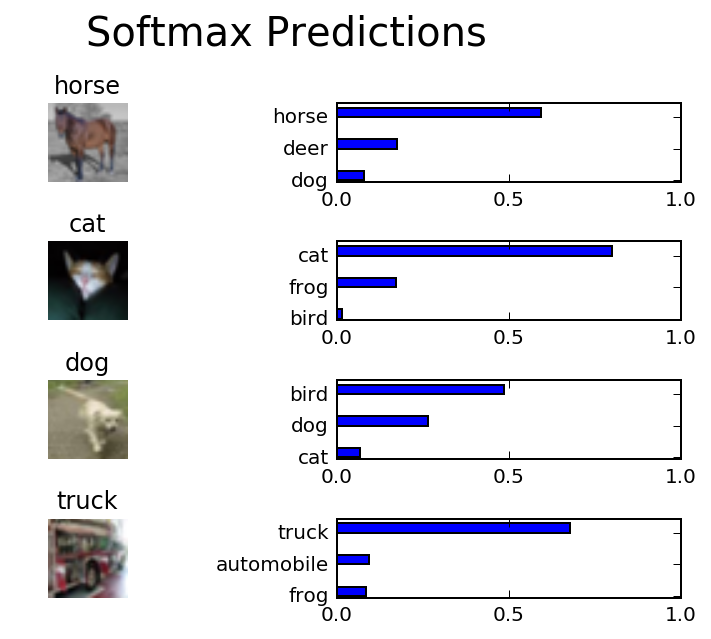

In [31]:

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

Pure guessing would get you 10% accuracy. We are hitting around 66.6% accuracy.